# Capstone Project: Battle of Berlin Neighborhoods

## Introduction

Customers are interested in opening up restaurants of different types and nationalities. So the distribution of restaurant types in Berlin neighborhoods is of interest. First, are restaurants, especially international ones, common for that area? Which ones are the most common types (and therefore maybe oversaturated)? How diverse is the distribution of restaurant types? And lastly, how similar are the neighborhoods based on their restaurant landscape (so if a certain restaurant type fits into one neighborhood, which other neighborhoods are suitable)?

## Data and Methodology

A list of Berlin neighborhoods is collected from Wikipedia. The coordinates of the neighborhoods are acquired with the geopy library. Information on restaurant categories in a neighborhood can then be obtained with Foursquare's API. Here, the coordinates of each neighborhood are passed and up to 100 venues of the section 'food' within a radius of 2000 m are collected. The radius is small enough that the exploration search queries don't intersect. The data is collected in pandas DataFrames, which enable various manipulations of data and clear overviews. Statistical information can also be obtained by using pandas. For similarity measures, scipy libraries for clustering and depicting a dendrogram (tree-like diagram of hierarchical clusters) are utilized. A cluster size can be set based on correlation among the neighborhood venues. Finally, a map is depicted which marks the neighborhood according to their cluster.

Example of information extracted from data:
A dataframe with the latitude and longitude values for each neighborhood, which were obtained via geopy.geolocator:

Neighborhood	Latitude	Longitude  
0	Mitte	52.517690	13.402376  
1	Pankow	52.597811	13.436383  
2	Friedrichshain-Kreuzberg	52.515306	13.461612  
3	Charlottenburg-Wilmersdorf	52.507856	13.263952  
4	Neukoelln	52.481150	13.435350  
5	Lichtenberg	52.532161	13.511893  
6	Marzahn-Hellersdorf	52.522523	13.587663  
7	Reinickendorf	52.604763	13.295287  
8	Steglitz-Zehlendorf	52.429205	13.229974  
9	Tempelhof-Schoeneberg	52.440603	13.373703  
10	Spandau	52.519267	13.195439  
11	Treptow-Koepenick	52.417893	13.600185  

Then, a dataframe with food venue information from Foursquare is created (with Venue Category being the information of highest interest), the first five entries are shown:

Neighborhood Neighborhood Latitude	Neighborhood Longitude Venue	Venue Category  
0	Mitte	52.51769	13.402376	Block House	Steakhouse  
1	Mitte	52.51769	13.402376	THE REED	Restaurant  
2	Mitte	52.51769	13.402376	Café 93	Café  
3	Mitte	52.51769	13.402376	Ma'loa Poké Bowl Poke Place  
4	Mitte	52.51769	13.402376	Rotisserie Weingrün	Restaurant  
...  

The categories can be one-hot encoded, so that each neighborhood has a listing of occurences (e.g. African Restaurant, American Restaurant,	Argentinian Restaurant,	Asian Restaurant,	Austrian Restaurant,	BBQ Joint,	Bagel Shop	...). There are 70 types in total.

Some statistical infos such as maximum frequency of a type, standard deviation etc. can be obtained with pandas describe():

Neighborhood	Number of restaurant types	Std dev Frequency	Variance	Maximum frequency  
0	Mitte	36	0.021841	0.000477	0.120000  
2	Friedrichshain-Kreuzberg	34	0.030861	0.000952	0.210000  
3	Charlottenburg-Wilmersdorf	31	0.026793	0.000718	0.151515  
...  

Also, a list with top venues of each neighborhood is created:

FRIEDRICHSHAIN-KREUZBERG  
Venue Frequency  
0 Café 0.21  
1 Vegetarian / Vegan Restaurant 0.10  
2 Pizza Place 0.09  
...  

Clusters are created with scipy's linkage() and depicted with dendrogram(). With the folium library a Berlin map with cluster markers is shown.

## Results

In [2]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json
import geopy
from geopy.geocoders import Nominatim 
import requests 
from pandas.io.json import json_normalize 
# Matplotlib and associated plotting modules
#import matplotlib.cm as cm
#import matplotlib.colors as colors
import folium 
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

### Obtain coordinates of Berlin and its neighborhoods

In [3]:
# A list of the 12 Berlin neighborhoods
berlin_nb = ['Mitte', 'Pankow', 'Friedrichshain-Kreuzberg', 'Charlottenburg-Wilmersdorf', 'Neukoelln', 'Lichtenberg',
             'Marzahn-Hellersdorf', 'Reinickendorf', 'Steglitz-Zehlendorf', 'Tempelhof-Schoeneberg', 'Spandau',
             'Treptow-Koepenick']

In [4]:
# lists for the latitudes and longitudes of each neighborhood
lats, longs = [], []

# obtain coordinates from geopy
for nb in berlin_nb:
    address = '{}, Berlin'.format(nb)
    geolocator = Nominatim(user_agent='capstone-project')
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    lats.append(latitude)
    longs.append(longitude)

In [5]:
# create a pandas dataframe with the coordinates for eac neighborhood
berlin_df = pd.DataFrame({'Neighborhood':berlin_nb, 'Latitude':lats, 'Longitude':longs})

In [6]:
berlin_df

,Latitude,Longitude,Neighborhood
0,52.517690,13.402376,Mitte
1,52.597811,13.436383,Pankow
2,52.515306,13.461612,Friedrichshain-Kreuzberg
3,52.507856,13.263952,Charlottenburg-Wilmersdorf
4,52.481150,13.435350,Neukoelln
5,52.532161,13.511893,Lichtenberg
6,52.522523,13.587663,Marzahn-Hellersdorf
7,52.604763,13.295287,Reinickendorf
8,52.429205,13.229974,Steglitz-Zehlendorf
9,52.440603,13.373703,Tempelhof-Schoeneberg


In [7]:
# obtain the coordinates of Berlin center to display the map 
address = 'Berlin'

geolocator = Nominatim(user_agent='capstone-project')
location = geolocator.geocode(address)
lat_berlin = location.latitude
lon_berlin = location.longitude

### Create a Berlin map with folium

In [10]:
# create a map of Berlin
map_berlin = folium.Map(location=[lat_berlin, lon_berlin], zoom_start=11)

# add markers for each neighborhood
for lat, lng, neighborhood in zip(berlin_df['Latitude'], berlin_df['Longitude'], berlin_df['Neighborhood']):
    label = str(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=15,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_berlin)  
    
map_berlin

### Collect food venues via Foursquare API

In [11]:
CLIENT_ID = 'xxx' 
CLIENT_SECRET = 'xxx' 
VERSION = '20190120' 

In [13]:
venues_list = []

# set explore radius, limit and section of interest
radius=2000
limit=1000
section='food'

for name, lat, lng in zip(berlin_df['Neighborhood'], berlin_df['Latitude'], berlin_df['Longitude']):
    
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&section={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit,
            section)

    results = requests.get(url).json()['response']['groups'][0]['items']
    
    venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['categories'][0]['name']) for v in results])

In [15]:
# create dataframe with food venues, category and coordinates
venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']    

In [16]:
# there are 553 venue entries in total
venues.shape

(553, 7)

In [17]:
venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Mitte,52.51769,13.402376,Block House,52.520469,13.405278,Steakhouse
1,Mitte,52.51769,13.402376,THE REED,52.522249,13.408036,Restaurant
2,Mitte,52.51769,13.402376,Café 93,52.522997,13.399752,Café
3,Mitte,52.51769,13.402376,Ma'loa Poké Bowl,52.523653,13.400399,Poke Place
4,Mitte,52.51769,13.402376,Rotisserie Weingrün,52.512630,13.402929,Restaurant


### Analyze neighborhoods

In [18]:
# count the food venues for each neighborhood

venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Charlottenburg-Wilmersdorf,66,66,66,66,66,66
Friedrichshain-Kreuzberg,100,100,100,100,100,100
Lichtenberg,28,28,28,28,28,28
Marzahn-Hellersdorf,12,12,12,12,12,12
Mitte,100,100,100,100,100,100
Neukoelln,100,100,100,100,100,100
Pankow,7,7,7,7,7,7
Reinickendorf,21,21,21,21,21,21
Spandau,45,45,45,45,45,45


There are highly varying amounts of food venues. Pankow only has 7 listed, Treptow-Köpenick 8, whereas Friedrichshain-Kreuzberg, Mitte and Neukoelln have 100 (maximum). 

In [19]:
# create one-hot features of the food venues, based on category

berlin_oh = pd.get_dummies(venues[['Venue Category']], prefix='', prefix_sep='')
berlin_oh['Neighborhood'] = venues['Neighborhood']

# move 'Neighborhood' to first column

fixed_columns = [berlin_oh.columns[-1]] + list(berlin_oh.columns[:-1])
berlin_oh = berlin_oh[fixed_columns]

In [22]:
# group the dataframe by Neighborhood and take the mean to get procentual amount of each category, and sum to get
# the total number of restaurants of each category

berlin_grouped = berlin_oh.groupby('Neighborhood').mean().reset_index()
berlin_summed = berlin_oh.groupby('Neighborhood').sum().reset_index()

In [24]:
# transpose dataframe with absolute numbers and set the neighborhood name as index

berlin_indexed = berlin_summed.set_index('Neighborhood')
berlin_indexed = berlin_indexed.T

# describe() offers statistical information on the dataframe

info = berlin_indexed.describe()

In [33]:
# collect information (the number of different restaurant types, the maximum for a type)

count_available = []
max_values = []

for nb in berlin_nb:
    counts = berlin_indexed[nb].value_counts().sum() # there are 70 categories
    count_zeros = berlin_indexed[nb].value_counts().get(key=0.00)
    count_available.append(counts - count_zeros)
    max_values.append(info[nb]['max'])   

berlin_infos = pd.DataFrame({'Neighborhood':berlin_nb, 'Number of restaurant types':count_available,
                             'Maximum number':max_values})

In [34]:
berlin_infos.sort_values('Number of restaurant types', ascending=False)

,Maximum number,Neighborhood,Number of restaurant types
0,12.0,Mitte,36
2,21.0,Friedrichshain-Kreuzberg,34
3,10.0,Charlottenburg-Wilmersdorf,31
4,26.0,Neukoelln,30
10,9.0,Spandau,25
9,7.0,Tempelhof-Schoeneberg,18
5,7.0,Lichtenberg,15
7,4.0,Reinickendorf,14
8,7.0,Steglitz-Zehlendorf,13
6,2.0,Marzahn-Hellersdorf,10


In [35]:
info

Neighborhood,Charlottenburg-Wilmersdorf,Friedrichshain-Kreuzberg,Lichtenberg,Marzahn-Hellersdorf,Mitte,Neukoelln,Pankow,Reinickendorf,Spandau,Steglitz-Zehlendorf,Tempelhof-Schoeneberg,Treptow-Koepenick
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,0.942857,1.428571,0.400000,0.171429,1.428571,1.428571,0.100000,0.300000,0.642857,0.400000,0.542857,0.114286
std,1.768367,3.086067,1.068658,0.449522,2.184076,3.487333,0.346828,0.729304,1.383502,1.147145,1.293078,0.362873
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.750000,0.000000
max,10.000000,21.000000,7.000000,2.000000,12.000000,26.000000,2.000000,4.000000,9.000000,7.000000,7.000000,2.000000


The highest number of different types of restaurants has Berlin-Mitte (with 36 types), closely followed by Friedrichshain-Kreuzberg with 34. Pankow and Treptow-Koepenick have less than 10 types, they also have a lower number of venues overall, so almost each restaurant is of a different type. The highest number of restaurants of one type has Neukoelln with 26 (which are Cafés). Standard deviation and variance correpsond to the mean number of restaurants of each category. These values are to some extent indicators of how evenly distributed different restaurant types are. A high mean would suggest that there are many categories present, a high standard deviation suggests that there is an uneven distribution of restaurant types. As an example, Mitte and Neukoelln both have a mean of 1.43. Mitte has a std of 2.18, whereas Neukoelln has a higher std of 3.48. It can be seen in the top 10 lists below that Mitte has indeed a slightly more regular distribution, and in Neukoelln Cafés are already 1/4 of the total restaurant types. 

### Top 10 restaurants of each neighborhood

In [36]:
# create a listing of the top 10 restaurant types in each neighborhood and the percentual frequency

num_top_venues = 10

for hood in berlin_grouped['Neighborhood']:
    print(hood.upper())
    temp = berlin_grouped[berlin_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['Venue','Frequency']
    temp = temp.iloc[1:]
    temp['Frequency'] = temp['Frequency'].astype(float)
    temp = temp.round({'Frequency': 2})
    print(temp.sort_values('Frequency', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

CHARLOTTENBURG-WILMERSDORF
                Venue  Frequency
0  Italian Restaurant       0.15
1                Café       0.12
2              Bakery       0.09
3   Indian Restaurant       0.05
4          Restaurant       0.05
5   German Restaurant       0.05
6         Pizza Place       0.05
7    Doner Restaurant       0.03
8  Chinese Restaurant       0.03
9  Mexican Restaurant       0.03


FRIEDRICHSHAIN-KREUZBERG
                           Venue  Frequency
0                           Café       0.21
1  Vegetarian / Vegan Restaurant       0.10
2                    Pizza Place       0.09
3             Falafel Restaurant       0.06
4             Italian Restaurant       0.05
5                         Bakery       0.05
6                   Burger Joint       0.04
7          Vietnamese Restaurant       0.03
8      Middle Eastern Restaurant       0.03
9              German Restaurant       0.03


LICHTENBERG
                      Venue  Frequency
0     Vietnamese Restaurant       0.25
1      

All in all, Cafès, bakeries, Italian and pizza places are present in almost all top 10's. There are many international restaurants in the top 10, such as Vietnamese, Falafel, Greek and Asian restaurants.

In [50]:
# create a list with the most common restaurant types in general

cats = []
counts = []

for cat in berlin_summed:
    if cat != 'Neighborhood':
        cats.append(cat)
        counts.append(berlin_summed[cat].sum())

category_counts = pd.DataFrame({'Category':cats, 'Count':counts})
category_counts.sort_values('Count', ascending=False)

,Category,Count
14,Café,84
37,Italian Restaurant,45
7,Bakery,42
31,German Restaurant,31
48,Pizza Place,29
69,Vietnamese Restaurant,24
51,Restaurant,20
68,Vegetarian / Vegan Restaurant,19
3,Asian Restaurant,14
23,Falafel Restaurant,14


The highest count have Cafés (84). Cafés are present in all top 10 lists, sometimes being top 1. 

### Cluster neighborhoods and create a dendrogram

In [51]:
# create a dataframe for clustering which only contains the features (category frequency)

datac = berlin_grouped[:]
datac = datac[datac.columns[1:]]

# create a cluster based on Pearson correlation between the categories

cluster = linkage(datac, metric='correlation')

In [52]:
# prepare labels for the dendrogram
labels = []

for idx in datac.index:
    labels.append(berlin_grouped.at[idx, 'Neighborhood'])

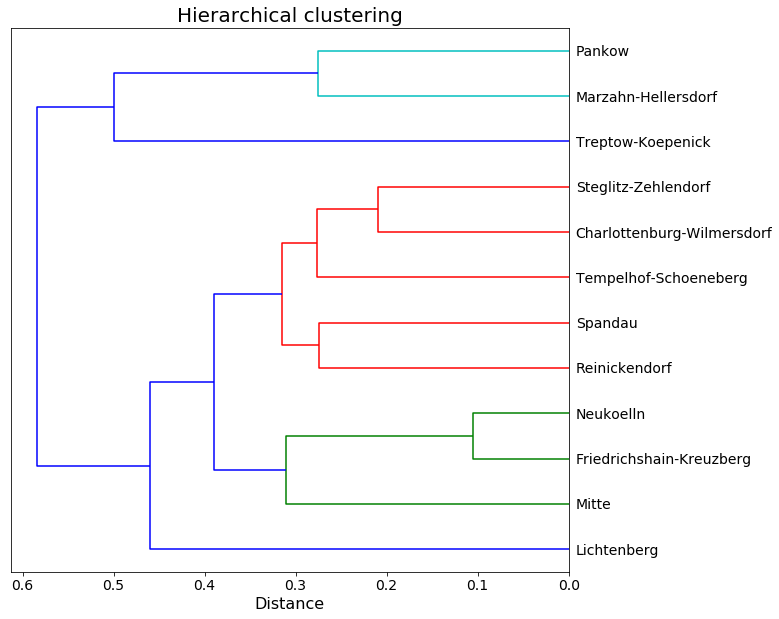

In [53]:
# a dendrogram depicts hierarchical clustering of the venue categories of the neighborhoods
# color threshold is set to 0.33 to obtain a relatively small set of clusters

plt.figure(figsize=(10,10))

dn = dendrogram(cluster, labels=labels, orientation='left', leaf_rotation=0, color_threshold=0.33)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Distance', fontsize=16)
plt.title('Hierarchical clustering', fontsize=20)

plt.show()

In [54]:
# order the neighborhoods with distances less than 0.33 into the three clusters (the cyan, red and green branches)
# (manually, not a good choice for larger datasets)

labels_ordered = dn['ivl']
cluster1 = labels_ordered[1:4]
cluster2 = labels_ordered[4:9]
cluster3 = labels_ordered[10:]

In [56]:
# assign cluster numbers to each neighborhood and add to main dataframe. The neighborhoods which are not in
# small-distance clusters are put into one cluster (4)

clabels = []
kclusters = 4

for idx, row in berlin_df.iterrows():
    if row['Neighborhood'] in cluster1:
        clabels.append(1)
    elif row['Neighborhood'] in cluster2:
        clabels.append(2)
    elif row['Neighborhood'] in cluster3:
        clabels.append(3)
    else:
        clabels.append(4)

berlin_df['Cluster label'] = clabels

### Create a map marking the different clusters

In [57]:
# create map of Berlin

map_clusters = folium.Map(location=[lat_berlin, lon_berlin], zoom_start=11)

# set color scheme for the clusters according to the branches in the dendrogram

colors = ['green', 'red', 'cyan', 'blue']

# add markers to the map

markers_colors = []
for lat, lon, poi, cluster in zip(berlin_df['Latitude'], berlin_df['Longitude'], berlin_df['Neighborhood'], berlin_df['Cluster label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=25,
        popup=label,
        color=colors[cluster-1],
        fill=True,
        fill_color=colors[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

It can be seen that the central neighborhoods are similar to each other, and so are the Western and, more or less, Northeastern neighborhoods (there were barely any restaurants listed). 

## Discussion

My recommendation would be to open a restaurant in the green, or red neighborhoods. However, it would depend on the type of restaurant. Some neighborhoods seem to have a lot of Cafés, so for opening up a Café a neighborhood where this category is not one of the highest occuring types might be a better choice (e.g. Pankow). For an 'exotic' restaurant such as a Ramen restaurant, a neighborhood with a higher number of different restaurant types could be more suited (e.g. the green clustered neighborhoods).   

There are some problems with the dataset. The neighborhoods are much denser in the center, so a fixed radius covers a lot of these neighborhoods, but not of the larger ones. The maximum venues obtained for each place (100) is also not very high. Looking at the results I suspect that the Foursquare database is either not complete or up to date. There are e.g. only 8 Döner restaurants listed and 1 Currywurst joint, that seems to be way too low.


## Conclusion
Food venues in the Berlin neighborhoods have been analyzed and clustered, and recommendations can be given according to the category of interest. Partly, not enough data was available to make significant analyses.